In [18]:
import torch
from dal_toolbox.datasets import CIFAR10
from dal_toolbox.datasets.utils import PlainTransforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [19]:
# Load dinov2
# dino_model_name = 'dinov2_vits14' # 21 M params
# dino_model_name = 'dinov2_vitb14' # 86 M params
# dino_model_name = 'dinov2_vitl14' # 300 M params
dino_model_name = 'dinov2_vitg14' # 1100 M params
dino_model = torch.hub.load('facebookresearch/dinov2', dino_model_name)

Using cache found in /home/dhuseljic/.cache/torch/hub/facebookresearch_dinov2_main


In [20]:
# Load data with no transforms
cifar = CIFAR10('/datasets', transforms=PlainTransforms(resize=(224, 224)))

Files already downloaded and verified
Files already downloaded and verified


In [21]:
class DinoFeatureDataset:

    @torch.no_grad()
    def __init__(self, dino_model, dataset, device):
        features, labels = self.get_dino_features(dino_model, dataset, device)

        self.features = features
        self.labels = labels
    
    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, idx: int):
        return self.features[idx], self.labels[idx]

    def get_dino_features(self, dino_model, dataset, device):
        dataloader = DataLoader(dataset, batch_size=512, num_workers=4)

        features = []
        labels = []
        dino_model.to(device)
        for batch in tqdm(dataloader):
            features.append(dino_model(batch[0].to(device)).to('cpu'))
            labels.append(batch[-1])
        features = torch.cat(features)
        labels = torch.cat(labels)
        return features, labels

In [22]:
train_ds = DinoFeatureDataset(dino_model, cifar.train_dataset, device='cuda')
val_ds = DinoFeatureDataset(dino_model, cifar.val_dataset, device='cuda')
test_ds = DinoFeatureDataset(dino_model, cifar.test_dataset, device='cuda')

100%|██████████| 20/20 [02:58<00:00,  8.94s/it]


In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_ds.features, train_ds.labels)
model.score(val_ds.features, val_ds.labels)

0.9934

In [25]:
from lightning import Trainer
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.deterministic.linear import LinearModel

net = LinearModel(1536, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)
model = DeterministicModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512)
trainer = Trainer(max_epochs=100)
trainer.fit(model, train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | LinearModel      | 15.4 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.061     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1407/1407 [00:01<00:00, 806.70it/s, v_num=19, train_loss=3e-6, val_loss=0.0322]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1407/1407 [00:01<00:00, 805.99it/s, v_num=19, train_loss=3e-6, val_loss=0.0322]


In [26]:
predictions = trainer.predict(model, dataloaders=val_loader)
logits = torch.cat([pred[0] for pred in predictions])
labels = torch.cat([pred[1] for pred in predictions])
(logits.argmax(-1) == labels).float().mean()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 552.30it/s]


tensor(0.9936)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=20)
model.fit(train_ds.features, train_ds.labels)
model.score(val_ds.features, val_ds.labels)

0.9848

## Analysis

In [29]:
import numpy as np
from sklearn.manifold import TSNE
np.random.seed(42)

train_features_tsne = TSNE().fit_transform(train_ds.features)

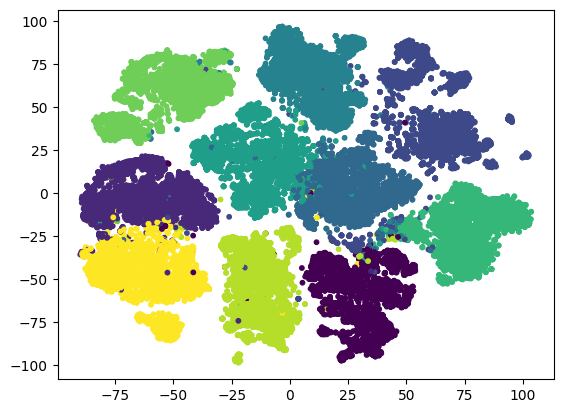

In [30]:
import pylab as plt

plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_ds.labels, s=10)

In [218]:
from sklearn.neighbors import NearestNeighbors

unlabeled_mask = np.array([True] * len(train_ds.features))
labeled_mask = np.array([False] * len(train_ds.features))

buy_indices = np.random.randint(len(train_ds), size=1000)
unlabeled_mask[buy_indices] = False
labeled_mask[buy_indices] = True

cand = train_ds.features[0]

nn = NearestNeighbors(n_neighbors=100)
nn.fit(train_ds.features)
dist, indices = nn.kneighbors(cand.reshape(1, -1))

k_cand = np.zeros(10)
# get indices which are labeled
is_labeled = labeled_mask[indices]
for idx, di in zip(indices[is_labeled], dist[is_labeled]):
    lbl = train_ds.labels[idx]
    inv_dist = 1/di
    print(lbl, inv_dist)
    k_cand[lbl] += 1 * inv_dist

prior = 1
k_cand 
(k_cand + prior) / (k_cand + prior).sum(keepdims=True)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [121]:
labeled_mask[indices]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True]])

In [84]:
# prior, how many samples have seen an label?

tensor(6)


In [128]:
import numpy as np
from sklearn.datasets import make_moons

X, y = make_moons(200, noise=.2)

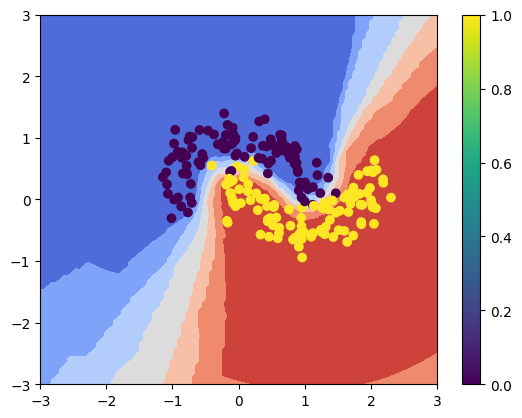

In [273]:
import numpy as np
from sklearn.datasets import make_moons

np.random.seed(1)
X, y = make_moons(200, noise=.2)

nn = NearestNeighbors(n_neighbors=20)
nn.fit(X)
dist, indices = nn.kneighbors(X)

def k_func(X, nn):
    K = []
    dist, indices = nn.kneighbors(X)
    for d, idx in zip(dist, indices):
        prior = 1
        k_vec = np.zeros(2) + prior
        for lbl, d_ in zip(y[idx], d):
            k_vec[lbl] += 1/d_
        K.append(k_vec)
    return np.array(K)

xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = np.c_[xx.ravel(), yy.ravel()]
K = k_func(zz, nn)

probas = K / K.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.colorbar()

# To simulate an update, I need to:
# Check for all samples if the added sample x will be in the neighborhood, not
# feasible, what if I just use all neighbors all the time, ignoring the need of
# a kernel func just use inverse distance


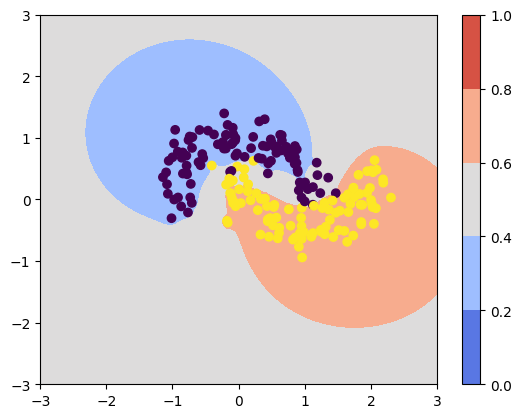

In [291]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels

np.random.seed(1)
X, y = make_moons(200, noise=.2)

def k_func(samples):
    S = pairwise_distances(samples, X)
    # S = pairwise_kernels(samples, X, metric='rbf', gamma=10)

    K = []
    for distances in S:
        prior=1

        k_vec = np.zeros(2) + prior
        for i_cls in range(2):
            dist_cls = distances[y == i_cls]
            inv_dist_cls = 1 / dist_cls
            inv_dist_cls[np.isinf(inv_dist_cls)] = 0
            k_vec[i_cls] += np.sum(inv_dist_cls)
        K.append(k_vec)
    return np.array(K)

xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = np.c_[xx.ravel(), yy.ravel()]
K = k_func(zz)

probas = K / K.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)